### Truncated BPTT

When the sequences are very long (thousands of points), the network training can be very slow and the memory requirements increase. The truncated BPTT is an alternative similar to mini-batch training in Dense Networks, even though in RNN the batch parameter can also be used.  

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo4/init.py
from init import init; init(force_download=False)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

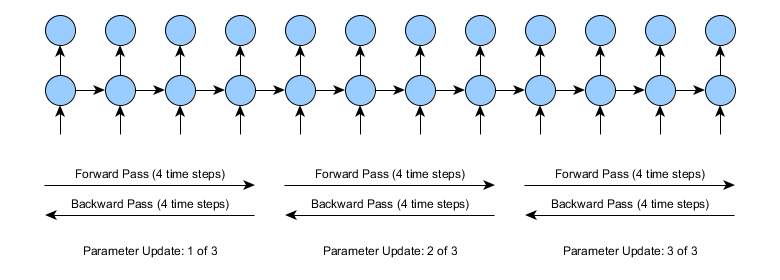

In [1]:
from IPython.display import Image
Image(filename='local/imgs/rnn_tbptt_2.png', width=1200)
#![alt text](local/imgs/rnn_tbptt_2.png "Truncated BPTT")

The TBPTT can be implemented by setting up the data appropriately. Let's remember that for recurrent neural networks, data must have the format **[n_samples,n_times,n_features]**, so if you want to use Truncated BPTT you just have to split the sequences into more **n_samples** of less **n_times**. 

### **BUT**, **Is it possible that the LSTM may find dependencies between the sequences?**

No it’s not possible unless you go for the stateful LSTM.

So the use of Truncated BPTT requires to set up the **Stateful** mode.

## Example

Extracted from: http://philipperemy.github.io/keras-stateful-lstm/

Let’s see a problem of classifying sequences. The data matrix $X$ is made exclusively of zeros except in the first column where exactly half of the values are 1.

In [5]:
import numpy as np
from numpy.random import choice
N_train = 1000
X_train = np.zeros((N_train,20))
one_indexes = choice(a=N_train, size=int(N_train / 2), replace=False)
X_train[one_indexes, 0] = 1  # very long term memory.
#--------------------------------
N_test = 200
X_test = np.zeros((N_test,20))
one_indexes = choice(a=N_test, size=int(N_test / 2), replace=False)
X_test[one_indexes, 0] = 1  # very long term memory.
print(X_train[:10,:5])
print(X_test[:10,:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [3]:
print(X_train.shape)

(1000, 20)


In [6]:
def prepare_sequences(x_train, y_train, window_length, increment):
    windows = []
    windows_y = []
    for i, sequence in enumerate(x_train):
        len_seq = len(sequence)
        for window_start in range(0, len_seq - window_length + 1, increment):
            window_end = window_start + window_length
            window = sequence[window_start:window_end]
            windows.append(window)
            windows_y.append(y_train[i])
    return np.array(windows), np.array(windows_y)

In [7]:
#Split the sequences into two sequences of length 10
window_length = 10

x_train, y_train = prepare_sequences(X_train, X_train[:,0], window_length,window_length)
x_test, y_test = prepare_sequences(X_test, X_test[:,0], window_length,window_length)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2000, 10, 1)
(2000, 1)
(400, 10, 1)
(400, 1)


Every sequence was split into 2 subsequences

In [8]:
print(x_train[:4,:])
print(y_train[:4,:])

[[[1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
[[1.]
 [1.]
 [0.]
 [0.]]


### Let's train a regular LSTM network

In [9]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

### Using the original sequences:

In [10]:
print('Building STATELESS model...')
max_len = 10
batch_size = 11
model = Sequential()
model.add(LSTM(10, input_shape=(20, 1), return_sequences=False, stateful=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape(1000,20,1), X_train[:,0].reshape(1000,1), batch_size=batch_size, epochs=5,
          validation_data=(X_test.reshape(200,20,1), X_test[:,0].reshape(200,1)), shuffle=False)
score, acc = model.evaluate(X_test.reshape(200,20,1),X_test[:,0].reshape(200,1), batch_size=batch_size, verbose=0)

Building STATELESS model...
Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6455 - accuracy: 0.5920 - val_loss: 0.3801 - val_accuracy: 1.0000
Epoch 2/5
1000/1000 [==============================] - 0s 439us/sample - loss: 0.2234 - accuracy: 1.0000 - val_loss: 0.1268 - val_accuracy: 1.0000
Epoch 3/5
1000/1000 [==============================] - 1s 761us/sample - loss: 0.0896 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 1.0000
Epoch 4/5
1000/1000 [==============================] - 1s 810us/sample - loss: 0.0504 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 5/5
1000/1000 [==============================] - 1s 544us/sample - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000


In [11]:
acc

1.0

### Using the splitted sequences:

In [12]:
print('Building STATELESS model...')
max_len = 10
batch_size = 2
model = Sequential()
model.add(LSTM(10, input_shape=(max_len, 1), return_sequences=False, stateful=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(x_test, y_test), shuffle=False)
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

Building STATELESS model...
Train on 2000 samples, validate on 400 samples
Epoch 1/15
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.5201 - accuracy: 0.7270 - val_loss: 0.4791 - val_accuracy: 0.7500
Epoch 2/15
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.4812 - accuracy: 0.7500 - val_loss: 0.4785 - val_accuracy: 0.7500
Epoch 3/15
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.4804 - accuracy: 0.7500 - val_loss: 0.4782 - val_accuracy: 0.7500
Epoch 4/15
2000/2000 [==============================] - 5s 2ms/sample - loss: 0.4800 - accuracy: 0.7500 - val_loss: 0.4781 - val_accuracy: 0.7500
Epoch 5/15
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.4797 - accuracy: 0.7500 - val_loss: 0.4780 - val_accuracy: 0.7500
Epoch 6/15
2000/2000 [==============================] - 7s 4ms/sample - loss: 0.4795 - accuracy: 0.7500 - val_loss: 0.4779 - val_accuracy: 0.7500
Epoch 7/15
2000/2000 [===========================

In [13]:
acc

0.75

The sequences composed of 0s are correctly classified. The subsequences starting with 1 are correctly classified, but the sebsequences of class 1 starting with 0, are wrong classified. Those are the 25% of the sequences.

### What happened?

The long range memory required to classify the sequences correctly has been lost because of the sequences' partition. 

### STATEFUL Model

In [14]:
print('Build STATEFUL model...')
max_len = 10
n_partitions = 2
batch = 1
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch, max_len, 1), return_sequences=False, stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Build STATEFUL model...


In [15]:
print('Train...')

for epoch in range(5):
    mean_tr_acc = []
    mean_tr_loss = []
    for i in range(0,x_train.shape[0],n_partitions):
        #print(i)
        for j in range(n_partitions):
            #print(j)
            tr_loss, tr_acc = model.train_on_batch(x_train[i+j,:,:].reshape(1,max_len,1), y_train[i+j,:].reshape(1,1))
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
        model.reset_states()    
    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')

    mean_te_acc = []
    mean_te_loss = []
    for i in range(0,x_test.shape[0],n_partitions):
        for j in range(n_partitions):
            te_loss, te_acc = model.test_on_batch(x_test[i+j,:,:].reshape(1,max_len,1), y_test[i+j,:].reshape(1,1))
            mean_te_acc.append(te_acc)
            mean_te_loss.append(te_loss)
        model.reset_states()

    print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
    print('loss testing = {}'.format(np.mean(mean_te_loss)))
    print('___________________________________')

Train...
accuracy training = 0.9605000019073486
loss training = 0.08138144016265869
___________________________________
accuracy testing = 1.0
loss testing = 0.0014561639400199056
___________________________________
accuracy training = 1.0
loss training = 0.0006937840953469276
___________________________________
accuracy testing = 1.0
loss testing = 0.0003019043360836804
___________________________________
accuracy training = 1.0
loss training = 0.0001738684659358114
___________________________________
accuracy testing = 1.0
loss testing = 9.1511283244472e-05
___________________________________
accuracy training = 1.0
loss training = 5.5697779316687956e-05
___________________________________
accuracy testing = 1.0
loss testing = 3.103803828707896e-05
___________________________________
accuracy training = 1.0
loss training = 1.9282120774732903e-05
___________________________________
accuracy testing = 1.0
loss testing = 1.0981940249621402e-05
___________________________________


The code was a bit more difficult to write because we have to manually call **model.reset_states()** at each new sequence processed. Another method to do that is to write a callback that reset the states at each sequence like this:

In [16]:
from tensorflow.keras.callbacks import Callback
n_partitions = 2
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % n_partitions == 0:
            self.model.reset_states()
        self.counter += 1
        
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch, max_len, 1), return_sequences=False, stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, callbacks=[ResetStatesCallback()], batch_size=1, shuffle=False)

Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 11s 5ms/sample - loss: 0.0740 - accuracy: 0.9625
Epoch 2/5
2000/2000 [==============================] - 10s 5ms/sample - loss: 4.8555e-04 - accuracy: 1.0000
Epoch 3/5
2000/2000 [==============================] - 12s 6ms/sample - loss: 1.2338e-04 - accuracy: 1.0000
Epoch 4/5
2000/2000 [==============================] - 10s 5ms/sample - loss: 3.9900e-05 - accuracy: 1.0000
Epoch 5/5
2000/2000 [==============================] - 8s 4ms/sample - loss: 1.3916e-05 - accuracy: 1.0000


When the dataset for validation have a different batchsize, the best way to solve it, is to create a new model with the new batchsize and transfer to it the weights of the trained model.

***Example**: The following code does not have relation with the previous examples!

In [ ]:
# configure network
n_batch = 3
n_epoch = 1000
n_neurons = 10
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(n_epoch):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    model.reset_states()
# re-define the batch size
n_batch = 1
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
new_model.add(Dense(1))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
# compile model
new_model.compile(loss='mean_squared_error', optimizer='adam')